In [41]:
# import packages to use 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from PIL import Image, ImageOps
import pandas as pd

In [9]:
# rescale image size, so the upload can be any size
big_teddy = Image.open("teddy.png")
small_image_size = 500 # editable variable for image size
rescaled_teddy = ImageOps.scale(big_teddy, factor=small_image_size/big_teddy.size[0]) 
rescaled_teddy.save("teddy_(small).png") # saves rescaled image each time to make it a continuous loop

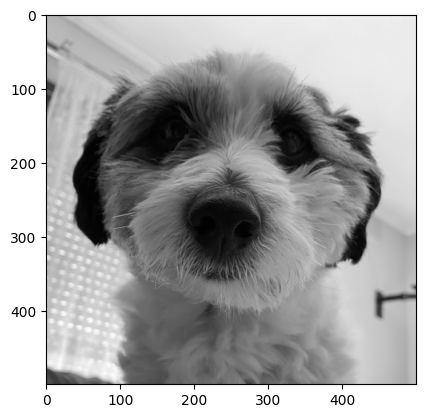

In [10]:
# Loads the resized image
teddy_image = io.imread('teddy_(small).png')

# Change to 8bit greyscale
teddy_image_grey = teddy_image.astype(np.uint8)
teddy_image_grey_vals = teddy_image_grey[:, :, 0] * 0.2989 + teddy_image_grey[:, :, 1] * 0.5870 + teddy_image_grey[:, :, 2] * 0.1140

plt.imshow(teddy_image_grey_vals, cmap='gray')
plt.show() # Removes the "Axes Image" printout

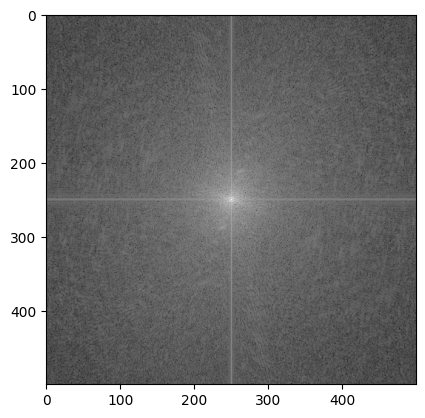

In [ ]:
# Produce a blurred version of the image
fourier_teddy = np.fft.fft2(teddy_image_grey_vals)
fourier_teddy_shifted = np.fft.fftshift(fourier_teddy)

# Rescale the Fourier transform for better visualization
fourier_teddy_rescaled = np.log(np.abs(fourier_teddy_shifted) + 1) # +1 to make log end at 0
plt.imshow(fourier_teddy_rescaled, cmap='gray')
plt.show() 

In [12]:
# There are different types of fourier filter transform representations, I will now try them.

# Each of theses functions create a mask in frequency space, applies said mask to the Fourier transformed image, visualises the result and then returns the filtered frequency image (blurred)
    # Frequency domain: How fast pixel intensities change, so you can target low or high frequencies
    # Low pass filter: keeps slow changes => makes smooth image
    # High filter: keeps fast changes => enhances edges

# create a circular mask centred at the middle of the fourrier image 
def filter_circle(fourier_image, cutoff, low=True): # Applies a circular low-pass or high-pass filter in the frequency domain
    # Default is to do a low pass filter
    # If set low to False, can also be a high pass filter

    rows, cols = fourier_image.shape

    # cutoff is the radius of the low-pass filter (fraction of image size)
    radius = int(cutoff * min(rows, cols) / 2)

    print(radius)

    # Create a mask for the low-pass filter
    mask = np.zeros((rows, cols), dtype=np.int8)
    if not low:
        mask = mask + 1
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - rows // 2) ** 2 + (j - cols // 2) ** 2) <= radius:
                if low:
                    mask[i, j] = 1
                else:
                    mask[i, j] = 0

    print(mask)

    # Apply the mask to the Fourier transform
    filtered_fourier = fourier_image * mask

    filtered_fourier_rescaled = np.log(np.abs(filtered_fourier) + 1)

    plt.close()
    plt.imshow(filtered_fourier_rescaled, cmap='gray')
    plt.show()

    return filtered_fourier

# create a square mask centred at the middle of the fourrier image 
def filter_square(fourier_image, cutoff, low=True):
    rows, cols = fourier_image.shape

    # cutoff is the radius of the low-pass filter (fraction of image size)
    radius = int(cutoff * min(rows, cols) / 2)

    print(radius)

    # Create a mask for the low-pass filter
    mask = np.zeros((rows, cols), dtype=np.int8)
    if not low:
        mask = mask + 1
    for i in range(rows):
        for j in range(cols):
            if np.abs(i - rows // 2) <= radius and np.abs(j - cols // 2) <= radius:
            # if np.abs(i - rows // 2) <= radius <= radius:
                if low:
                    mask[i, j] = 1
                else:    
                    mask[i, j] = 0

    print(mask)

    # Apply the mask to the Fourier transform
    filtered_fourier = fourier_image * mask

    filtered_fourier_rescaled = np.log(np.abs(filtered_fourier) + 1)
    plt.close()
    plt.imshow(filtered_fourier_rescaled, cmap='gray')
    plt.show()

    return filtered_fourier

# create a hamming mask (kaiser window) centred at the middle of the fourrier image 
def low_pass_filter_hamming(fourier_image, cutoff):
    rows, cols = fourier_image.shape

    # cutoff is the radius of the low-pass filter (fraction of image size)
    radius = int(cutoff * min(rows, cols) / 2)
    print(radius)


    # Create a mask for the low-pass filter
    hamming_window = np.kaiser(radius*2, 9)[:, None]
    # hamming_window = np.bartlett(radius*2)[:, None]
    hamming_window = np.concat((np.zeros((rows // 2 - radius, 1)), hamming_window, np.zeros((rows // 2 - radius, 1))), axis=0)
    hamming_window_2d = np.sqrt(hamming_window * hamming_window.T)
    filtered_fourier = fourier_image * hamming_window_2d

    filtered_fourier_rescaled = np.log(np.abs(filtered_fourier) + 1)
    plt.close()
    plt.imshow(filtered_fourier_rescaled, cmap='gray')
    plt.show()

    return filtered_fourier

125
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


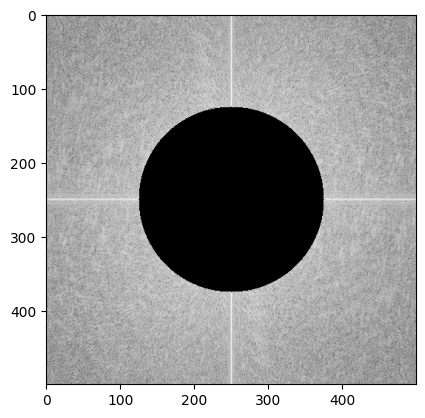

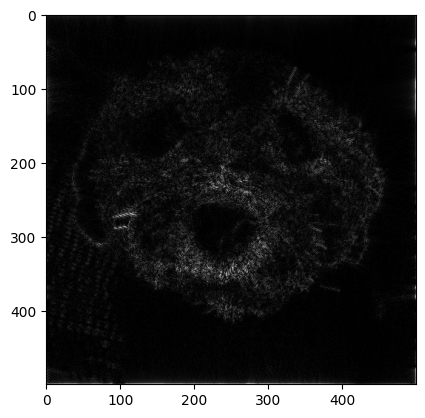

In [ ]:
# Teddy blurred but cursed
# Circle filter
fourier_teddy_filtered = filter_circle(fourier_teddy_shifted, 0.5, low=False)
inv_fourer_teddy_filtered = np.fft.ifft2(fourier_teddy_filtered)
plt.imshow(np.abs(inv_fourer_teddy_filtered), cmap='gray')
plt.show()

12
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


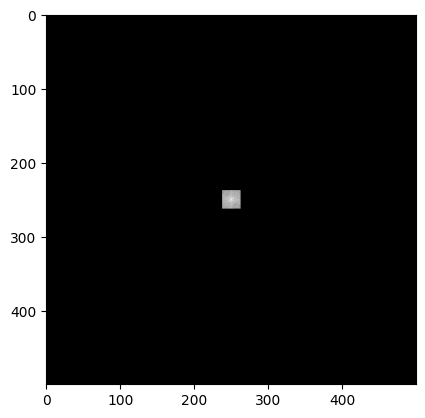

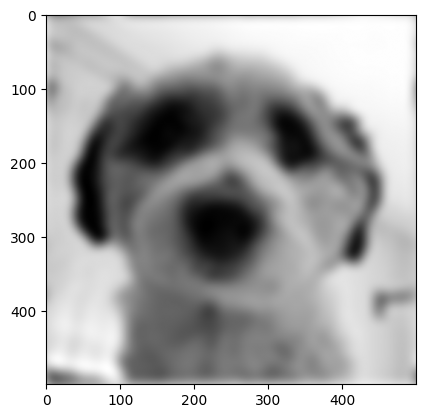

In [ ]:
# Teddy but fuzzy
# Square filter
fourier_teddy_filtered_square = filter_square(fourier_teddy_shifted, 0.05)
inv_fourer_teddy_filtered_square = np.fft.ifft2(fourier_teddy_filtered_hamming)
plt.imshow(np.abs(inv_fourer_teddy_filtered_square), cmap='gray')
plt.show()

25


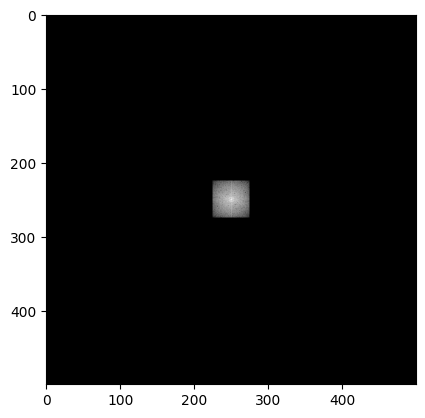

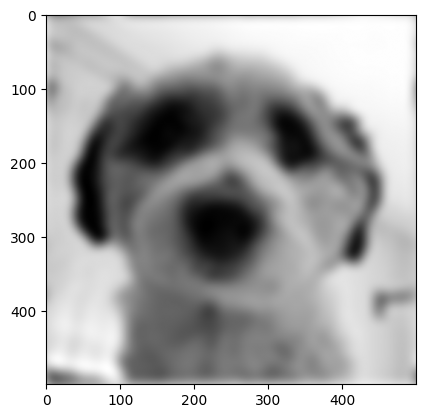

In [28]:
# I like this one
# Hamming filter
fourier_teddy_filtered_hamming = low_pass_filter_hamming(fourier_teddy_shifted, 0.1)
inv_fourer_teddy_filtered_hamming = np.abs(np.fft.ifft2(fourier_teddy_filtered_hamming))
# Fourier transform may return complex numbers. We are interested in the magnitude of these numbers, so we take the absolute value.
plt.imshow(inv_fourer_teddy_filtered_hamming, cmap='gray')
plt.show()

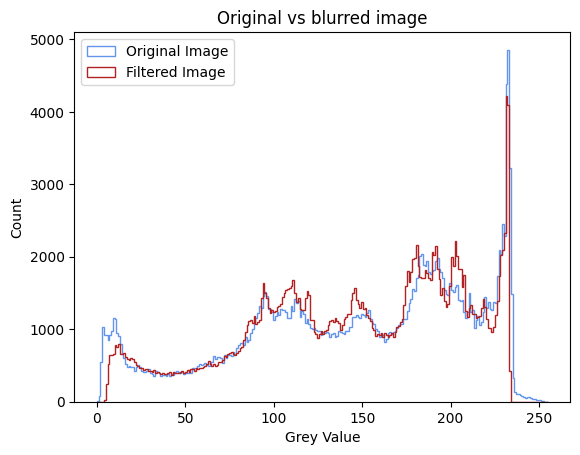

In [40]:
# plot histogram of original and blurred image
plt.hist(teddy_image_grey_vals.flatten(), bins=256, range=(0, 255), histtype='step', label='Original Image', color='cornflowerblue')
plt.hist(inv_fourer_teddy_filtered_hamming.flatten(), bins=256, range=(0, 255), histtype='step', label='Filtered Image', color='firebrick')
plt.xlabel('Grey Value')
plt.ylabel('Count')
plt.title('Original vs blurred image')
plt.legend()
plt.show()

In [45]:
# calculate stats
original_stats = stats.describe(teddy_image_grey_vals.flatten())
filtered_stats = stats.describe(np.abs(inv_fourer_teddy_filtered_hamming.flatten()))

# organise stats into a dataframe
# Kurtosis: measure of the tailedness of a distribution (how often outliers occur)
    # Negative = flatter distribution, lighter tails
# Skewness: measure of the asymmetry of a distribution
    # Negative = left
stats_table = pd.DataFrame({
    'Statistic': ['Min','Max','Mean','Variance','Skewness','Kurtosis'], 
    'Original Image': [
        original_stats.minmax[0], #min
        original_stats.minmax[1], #max
        original_stats.mean,
        original_stats.variance,
        original_stats.skewness,
        original_stats.kurtosis
    ],
    'Filtered Image': [
        filtered_stats.minmax[0],
        filtered_stats.minmax[1],
        filtered_stats.mean,
        filtered_stats.variance,
        filtered_stats.skewness,
        filtered_stats.kurtosis
    ]
})

#print table
print(stats_table.to_string(index=False))
stats_table.to_csv('image_statistics.csv', index=False)

Statistic  Original Image  Filtered Image
      Min        0.000000        4.814087
      Max      252.583300      233.830721
     Mean      144.521968      144.269488
 Variance     4268.225207     3690.469921
 Skewness       -0.468802       -0.441162
 Kurtosis       -0.790541       -0.737587


In [ ]:
#saves filtered image
io.imsave('teddy_filtered.png', inv_fourer_teddy_filtered_hamming.astype(np.uint8))

In [ ]:
#scales filtered image by half
scaled_image = np.zeros((inv_fourer_teddy_filtered_hamming.shape[0] // 2, inv_fourer_teddy_filtered_hamming.shape[1] // 2))
for x_pix in range(0, inv_fourer_teddy_filtered_hamming.shape[0], 2):
    for y_pix in range(0, inv_fourer_teddy_filtered_hamming.shape[1], 2):
        scaled_image[x_pix // 2, y_pix // 2] = np.mean(inv_fourer_teddy_filtered_hamming[x_pix:x_pix+2,y_pix:y_pix+2].flatten())

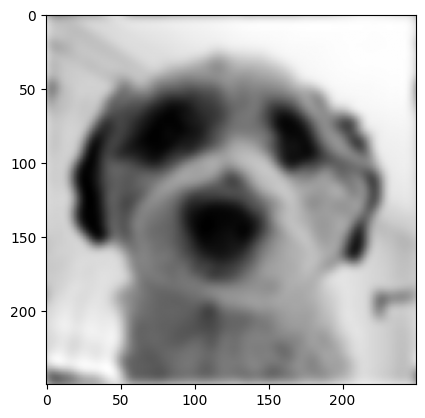

In [ ]:
# shows and saves downscaled filtered image
plt.imshow(scaled_image, cmap='grey')
io.imsave('teddy_filtered_mini.png', scaled_image.astype(np.uint8))